# READING IN NECESSARY FILES

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# READ IN FILES FROM DIRECTORY H5
files = os.listdir(os.path.join(os.getcwd(), 'h5'))

# SEPARATE FILES INTO LTE AND NLTE
lte_files = [os.path.join(os.getcwd(), 'h5', file) for file in files if 'nlte' not in str(file)]
nlte_files = [os.path.join(os.getcwd(), 'h5', file) for file in files if 'nlte' in str(file)]

# READ IN ORIGINAL MEASURED SPECTRUM
org_data = pd.read_csv(os.path.join(os.getcwd(), 'uves_spectra_fomalhaut.csv'))
org_wl = np.array(org_data['WL'].to_list())
org_flux = np.array(org_data['Flux'].to_list())

# READ IN FIRST FILE OF THE NLTE FILES TO TEST ON
content = h5py.File(nlte_files[0], 'r')
wl = np.array(content['PHOENIX_SPECTRUM']['wl'][()])
flux = np.array(10.**content['PHOENIX_SPECTRUM']['flux'][()])

# USE TO GET OTHER DATA ABOUT THE H5 FILE IF NEEDED
print(list(content.keys()))
print(list(content['PHOENIX_SPECTRUM'].keys()))

['PHOENIX_SPECTRUM']
['bb', 'chunky', 'flux', 'nwl', 'wl']


# FUNCTIONS FOR TRANSFORMING DATA

In [6]:
def gauss_smooth(wl,fl,start,end,res,oversampling=50.):
    """ smooth a data set (x,y) to a given resolution with a Gauss function
    
    input:
        wl   : input wavelength (sorted, but not equally spaced)
        fl   : fluxes (etc) (x)
        start: beginning wavelength
        end  :  end wavelength
        res  : target wavelength resolution (ca. FWHM)
        oversampling: (optional) oversampling factor, default 50.
    output:
        wl_res,f_res: regular wavelength grid with F smoothed.

    needs: 
        numpy (np), astropy
    """
    from astropy.convolution import convolve_fft, Gaussian1DKernel
#
# oversampling factor: 
#
    if(oversampling is None):
      oversampling = 50.0

#    print oversampling
#
# make target wavelength array [start,end] with 10 times gives resolution (oversampling)
#
    n_points = int((end-start)*oversampling/res+1)
    wl_res = np.linspace((start),(end),n_points)
#
# interpolate input fluxes[wl] to wl_res:
# this is piecewise linear.
#
    fl_res = np.interp(wl_res,wl,fl)
#
# set up and perform FFT based convolution.
# res (delta lambda) = 2*stddev^2 in physical units
# astropy wants this in pixel: The size of a pixel is res/oversampling in Angstroem, so 
#
#    stddev = np.sqrt(0.5*res/oversampling)
#    stddev = np.sqrt(0.5*oversampling)
    stddev = oversampling
#    print res,stddev
    fl_smooth = convolve_fft(fl_res,Gaussian1DKernel(stddev))
    return wl_res,fl_smooth

# Funktion zur Normalisierung des Flusses basierend auf dem Integral
def normalize_flux(wavelengths, fluxes):
    total_integral = np.trapezoid(fluxes, wavelengths)
    # print(f"Total Integral: {total_integral}")
    non_zero_indices = np.nonzero(fluxes)[0]
    if len(non_zero_indices) > 0:
        first = non_zero_indices[0]
        last = non_zero_indices[-1]
        distance = wavelengths[last] - wavelengths[first]
        # print(f"Normalization Range: {wavelengths[first]} to {wavelengths[last]}, Distance: {distance}")
        normalized_fluxes = fluxes / total_integral * int(distance)
        # print(f"Normalized Flux Integral: {np.trapezoid(normalized_fluxes, wavelengths)}")
        return normalized_fluxes
    return fluxes  # Originalen Fluss zurückgeben, wenn keine Nicht-Null-Werte vorhanden sind

def calculate_quality(original_flux, synthetic_flux):
    """
    Berechnet die Qualität der Übereinstimmung zwischen zwei Spektren basierend auf der gegebenen Formel.

    Parameters:
        original_flux (array): Normalisierter Fluss des Originalspektrums
        synthetic_flux (array): Normalisierter Fluss des synthetischen Spektrums (nach Verschiebung)

    Returns:
        float: Qualitätswert Q
    """
    if len(original_flux) != len(synthetic_flux):
        raise ValueError("Die beiden Spektren müssen die gleiche Länge haben, um Q zu berechnen.")

    # Berechnung von Q
    Q = np.mean((original_flux - synthetic_flux) ** 2)
    return Q

# Interpolationsfunktion mit und ohne Wellenlängenverschiebung
def interpolate_spectrum(wavelengths, fluxes, target_wavelengths):
    """
    Interpoliert die Spektren auf die Ziel-Wellenlängen.
    """
    interp_func = interp1d(wavelengths, fluxes, kind="linear", bounds_error=False, fill_value=0)
    return interp_func(target_wavelengths)

# Funktion zur Normalisierung gemäß Gleichung (18)
def normalize_flux_to_unity(fluxes):
    """
    Normalisiert den Fluss so, dass der Gesamtfluss auf 1 normiert ist.
    """
    total_flux = np.sum(fluxes)
    if total_flux > 0:
        return fluxes / total_flux
    return fluxes



# TRANSFORMING SPECTRUM

Total Integral: 8463665320.169781
Normalization Range: 3800.0092034 to 4879.9930684, Distance: 1079.9838650000002
Normalized Flux Integral: 1079.0
Total Integral: 5.663920040258526e+18
Normalization Range: 3800.001524544 to 4879.998927072, Distance: 1079.9974025279998
Normalized Flux Integral: 1079.0
[0.45119352 0.45194441 0.45798168 ... 0.71018824 0.7076883  0.72652692]
[0.51177342 0.51209653 0.51241931 ... 0.73944464 0.73944529 0.73944596]


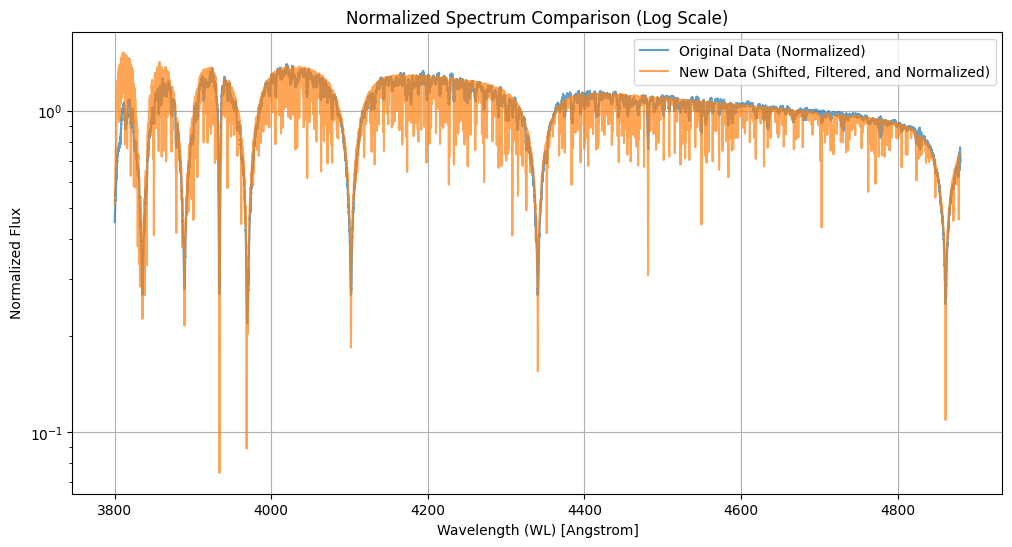

In [110]:
# VARIABLES NEEDED
res = .1
xrange = [2000., 9000.]
yrange = [1e15, 1.1e17]

# org_wl, org_flux = gauss_smooth(org_wl, 10.**org_flux, xrange[0]-res*2, xrange[1]+res*2, res)
wl, flux = gauss_smooth(wl, flux, xrange[0]-res*2, xrange[1]+res*2, res)

# Definiere den Bereich des Originaldatensatzes
org_min_wl, org_max_wl = min(org_wl), max(org_wl)

# Filter beide Datensätze auf den Bereich 3800 bis 5000 Angström
filter_range = (3800, 4880)

# Filter Originaldaten
org_filtered_indices = (org_wl >= filter_range[0]) & (org_wl <= filter_range[1])
org_wl_filtered = org_wl[org_filtered_indices]
org_flux_filtered = org_flux[org_filtered_indices]


# Different approaches of calculation used in old Jupyter NoteBook
gate = True

if gate:
    # Wellenlängenverschiebung auf die "New Data" Wellenlängen anwenden
    shift_factor = 0.999731
    wl_shifted = wl * shift_factor  # Verschiebung der Wellenlängen
    
    # Filter die verschobenen neuen Daten
    new_filtered_indices = (wl_shifted >= filter_range[0]) & (wl_shifted <= filter_range[1])
    wl_filtered = wl_shifted[new_filtered_indices]
    flux_filtered = flux[new_filtered_indices]
else:
    # Filter neue Daten
    new_filtered_indices = (wl >= filter_range[0]) & (wl <= filter_range[1])
    wl_filtered = wl[new_filtered_indices]
    flux_filtered = flux[new_filtered_indices]

# Normalisiere die gefilterten Daten
org_normalized_flux = normalize_flux(org_wl_filtered, org_flux_filtered)
new_normalized_flux = normalize_flux(wl_filtered, flux_filtered)

# Drucke die normalisierten Fluss-Arrays für den gefilterten Bereich
print(org_normalized_flux)
print(new_normalized_flux)

# Plot der normalisierten Spektren mit den gefilterten Daten
plt.figure(figsize=(12, 6))
plt.title("Normalized Spectrum Comparison (Log Scale)")

# Plot der normalisierten Original- und neuen Flüsse
plt.plot(org_wl_filtered, org_normalized_flux, label="Original Data (Normalized)", color="C0", alpha=0.7)
plt.plot(wl_filtered, new_normalized_flux, label="New Data (Shifted, Filtered, and Normalized)", color="C1", alpha=0.7)

# Beschriftungen, Legende und Logarithmische Skalierung der y-Achse
plt.xlabel("Wavelength (WL) [Angstrom]")
plt.ylabel("Normalized Flux")
plt.yscale("log")
plt.legend()
plt.grid()

# Zeige den Plot an
plt.show()

Total Integral: 8459065419.658009
Normalization Range: 3801.0 to 4879.899999999019, Distance: 1078.8999999990192
Normalized Flux Integral: 1078.0000000000002
Total Integral: 5.655169631412472e+18
Normalization Range: 3801.0 to 4878.59999999902, Distance: 1077.59999999902
Normalized Flux Integral: 1076.9999999999998
Total Integral: 8459065419.658009
Normalization Range: 3801.0 to 4879.899999999019, Distance: 1078.8999999990192
Normalized Flux Integral: 1078.0000000000002
Total Integral: 5.660418821042981e+18
Normalization Range: 3801.0 to 4879.899999999019, Distance: 1078.8999999990192
Normalized Flux Integral: 1078.0


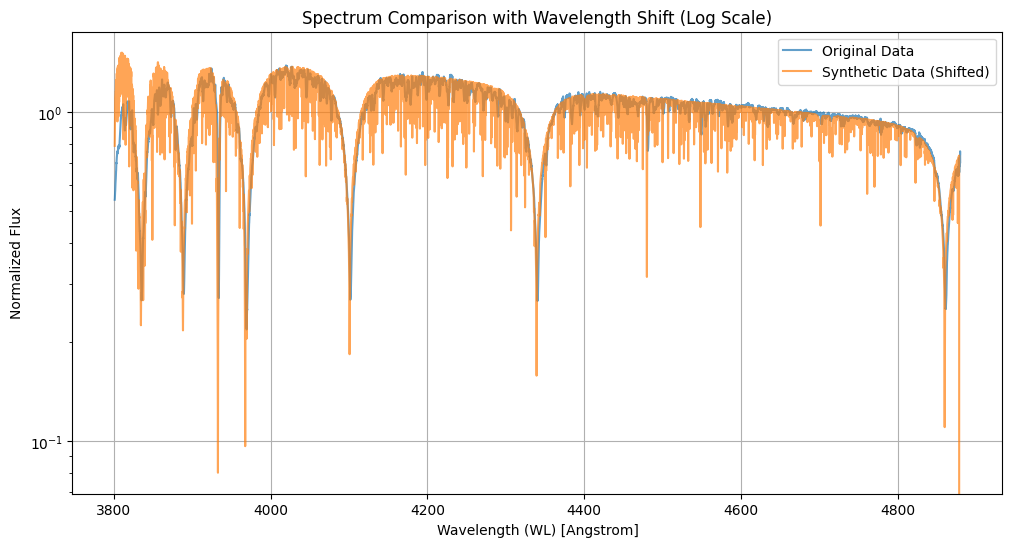

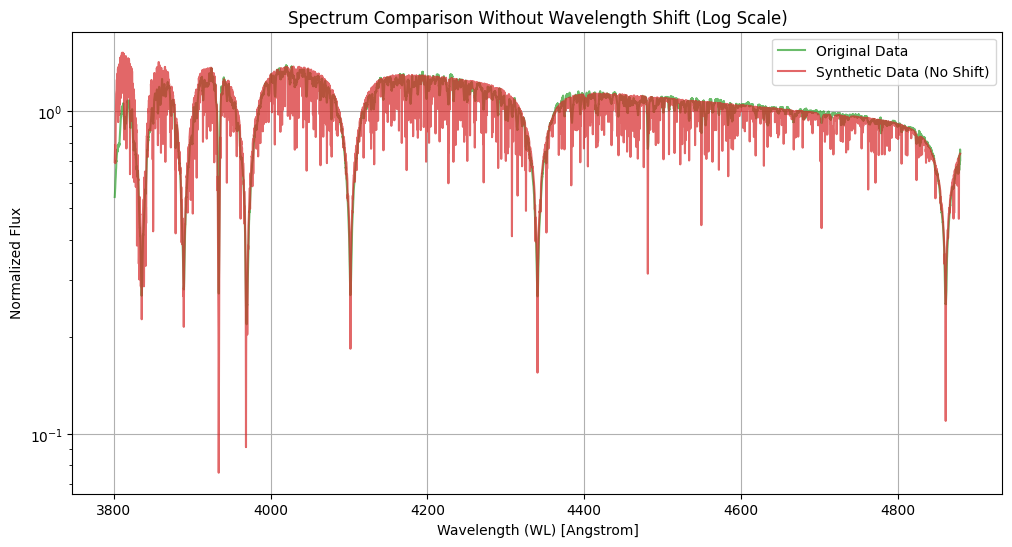

Qualitätswert mit Wellenlängenverschiebung: 0.015798309858925327
Qualitätswert ohne Wellenlängenverschiebung: 0.01071820599382438


In [111]:
# Ziel-Wellenlängen (Interpolation auf 100 Werte pro Ångström)
target_wavelengths = np.arange(3801, 4880, 0.1)  # Fein aufgelöste Ziel-Wellenlängen

# Interpolation MIT Wellenlängenverschiebung
shifted_wavelengths = wl_filtered * 0.999731  # Verschiebung des synthetischen Spektrums
org_interpolated_flux = interpolate_spectrum(org_wl_filtered, org_flux_filtered, target_wavelengths)
new_interpolated_flux_shifted = interpolate_spectrum(shifted_wavelengths, flux_filtered, target_wavelengths)

# Normalisierung MIT Wellenlängenverschiebung
org_normalized_flux_shifted = normalize_flux(target_wavelengths, org_interpolated_flux)
new_normalized_flux_shifted = normalize_flux(target_wavelengths, new_interpolated_flux_shifted)

# Interpolation OHNE Wellenlängenverschiebung
org_interpolated_flux_no_shift = interpolate_spectrum(org_wl_filtered, org_flux_filtered, target_wavelengths)
new_interpolated_flux_no_shift = interpolate_spectrum(wl_filtered, flux_filtered, target_wavelengths)

# Normalisierung OHNE Wellenlängenverschiebung
org_normalized_flux_no_shift = normalize_flux(target_wavelengths, org_interpolated_flux_no_shift)
new_normalized_flux_no_shift = normalize_flux(target_wavelengths, new_interpolated_flux_no_shift)

# Plot MIT Wellenlängenverschiebung
plt.figure(figsize=(12, 6))
plt.title("Spectrum Comparison with Wavelength Shift (Log Scale)")
plt.plot(target_wavelengths, org_normalized_flux_shifted, label="Original Data", color="C0", alpha=0.7)
plt.plot(target_wavelengths, new_normalized_flux_shifted, label="Synthetic Data (Shifted)", color="C1", alpha=0.7)
plt.xlabel("Wavelength (WL) [Angstrom]")
plt.ylabel("Normalized Flux")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

# Plot OHNE Wellenlängenverschiebung
plt.figure(figsize=(12, 6))
plt.title("Spectrum Comparison Without Wavelength Shift (Log Scale)")
plt.plot(target_wavelengths, org_normalized_flux_no_shift, label="Original Data", color="C2", alpha=0.7)
plt.plot(target_wavelengths, new_normalized_flux_no_shift, label="Synthetic Data (No Shift)", color="C3", alpha=0.7)
plt.xlabel("Wavelength (WL) [Angstrom]")
plt.ylabel("Normalized Flux")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

# Berechnung der Qualitätswerte
try:
    # Mit Verschiebung
    Q_with_shift = calculate_quality(org_normalized_flux_shifted, new_normalized_flux_shifted)
    print(f"Qualitätswert mit Wellenlängenverschiebung: {Q_with_shift}")
    
    # Ohne Verschiebung
    Q_without_shift = calculate_quality(org_normalized_flux_no_shift, new_normalized_flux_no_shift)
    print(f"Qualitätswert ohne Wellenlängenverschiebung: {Q_without_shift}")
except ValueError as e:
    print(f"Fehler bei der Berechnung der Qualitätswerte: {e}")


# FUNCTION WHICH UNIFIES ALL INTO CALCULATING THE QUALITY VALUE

In [2]:
def calculate_quality_value(flux, wl, org_flux, org_wl):
    # VARIABLES NEEDED
    res = .6
    xrange = [2000., 9000.]
    # yrange = [1e15, 1.1e17]

    # org_wl, org_flux = gauss_smooth(org_wl, 10.**org_flux, xrange[0]-res*2, xrange[1]+res*2, res)
    wl, flux = gauss_smooth(wl, flux, xrange[0]-res*2, xrange[1]+res*2, res)

    # Definiere den Bereich des Originaldatensatzes
    # org_min_wl, org_max_wl = min(org_wl), max(org_wl)

    # Filter beide Datensätze auf den Bereich 3800 bis 5000 Angström
    filter_range = (3800, 4880)

    # Filter Originaldaten
    org_filtered_indices = (org_wl >= filter_range[0]) & (org_wl <= filter_range[1])
    org_wl_filtered = org_wl[org_filtered_indices]
    org_flux_filtered = org_flux[org_filtered_indices]


    # Different approaches of calculation used in old Jupyter NoteBook
    gate = False

    if gate:
        # Wellenlängenverschiebung auf die "New Data" Wellenlängen anwenden
        shift_factor = 0.999731
        wl_shifted = wl * shift_factor  # Verschiebung der Wellenlängen
        
        # Filter die verschobenen neuen Daten
        new_filtered_indices = (wl_shifted >= filter_range[0]) & (wl_shifted <= filter_range[1])
        wl_filtered = wl_shifted[new_filtered_indices]
        flux_filtered = flux[new_filtered_indices]
    else:
        # Filter neue Daten
        new_filtered_indices = (wl >= filter_range[0]) & (wl <= filter_range[1])
        wl_filtered = wl[new_filtered_indices]
        flux_filtered = flux[new_filtered_indices]

    # Ziel-Wellenlängen (Interpolation auf 100 Werte pro Ångström)
    target_wavelengths = np.arange(3801, 4880, 0.8)  # Fein aufgelöste Ziel-Wellenlängen

    # Interpolation MIT Wellenlängenverschiebung
    shifted_wavelengths = wl_filtered * 0.999731  # Verschiebung des synthetischen Spektrums
    org_interpolated_flux = interpolate_spectrum(org_wl_filtered, org_flux_filtered, target_wavelengths)
    new_interpolated_flux_shifted = interpolate_spectrum(shifted_wavelengths, flux_filtered, target_wavelengths)

    # Normalisierung MIT Wellenlängenverschiebung
    org_normalized_flux_shifted = normalize_flux(target_wavelengths, org_interpolated_flux)
    new_normalized_flux_shifted = normalize_flux(target_wavelengths, new_interpolated_flux_shifted)

    # Interpolation OHNE Wellenlängenverschiebung
    org_interpolated_flux_no_shift = interpolate_spectrum(org_wl_filtered, org_flux_filtered, target_wavelengths)
    new_interpolated_flux_no_shift = interpolate_spectrum(wl_filtered, flux_filtered, target_wavelengths)

    # Normalisierung OHNE Wellenlängenverschiebung
    org_normalized_flux_no_shift = normalize_flux(target_wavelengths, org_interpolated_flux_no_shift)
    new_normalized_flux_no_shift = normalize_flux(target_wavelengths, new_interpolated_flux_no_shift)

    # Berechnung der Qualitätswerte
    try:
        # Mit Verschiebung
        Q_with_shift = calculate_quality(org_normalized_flux_shifted, new_normalized_flux_shifted)
        # print(f"Qualitätswert mit Wellenlängenverschiebung: {Q_with_shift}")
        
        # Ohne Verschiebung
        Q_without_shift = calculate_quality(org_normalized_flux_no_shift, new_normalized_flux_no_shift)
        # print(f"Qualitätswert ohne Wellenlängenverschiebung: {Q_without_shift}")
    except ValueError as e:
        print(f"Fehler bei der Berechnung der Qualitätswerte: {e}")
        return 'Failed'
    
    return (Q_with_shift, Q_without_shift)

# calculate_quality_value(flux, wl, org_flux, org_wl)

# READING ALL FILES IN AND MAPPING THEM
## Dont forget to initialize the Functions Code block, its needed for this

In [18]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# READ IN FILES FROM DIRECTORY H5
files = os.listdir(os.path.join(os.getcwd(), 'h5'))

# SEPARATE FILES INTO LTE AND NLTE
lte_files = [os.path.join(os.getcwd(), 'h5', file) for file in files if 'nlte' not in str(file)]
nlte_files = [os.path.join(os.getcwd(), 'h5', file) for file in files if 'nlte' in str(file)]

# READ IN ORIGINAL MEASURED SPECTRUM
org_data = pd.read_csv(os.path.join(os.getcwd(), 'uves_spectra_fomalhaut.csv'))
org_wl = np.array(org_data['WL'].to_list())
org_flux = np.array(org_data['Flux'].to_list())
results = dict()

for file in nlte_files:
    print(file)

    teff = file.split('\\')[-1][4:9]
    logg = file.split('\\')[-1][10:14]
    z_scale = file.split('\\')[-1][15:18]

    # READ IN FIRST FILE OF THE NLTE FILES TO TEST ON
    content = h5py.File(file, 'r')
    
    wl = np.array(content['PHOENIX_SPECTRUM']['wl'][()])
    flux = np.array(10.**content['PHOENIX_SPECTRUM']['flux'][()])

    # USE TO GET OTHER DATA ABOUT THE H5 FILE IF NEEDED
    # print(list(content.keys()))
    # print(list(content['PHOENIX_SPECTRUM'].keys()))
    quality = calculate_quality_value(flux, wl, org_flux, org_wl)
    results[str(file.split('\\')[-1])] = {
        'teff': teff,
        'logg': logg,
        'z_scale': z_scale,
        'Quality_shifted': quality[0],
        'Quality_unshifted': quality[1],
    }

print(results)
import json

with open('results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=4)

c:\Users\franj\Downloads\misc\misc\h5\nlte08100-4.25+0.2.FULL.PHOENIX-NewEra-SESAM-COND-2023.hummel2.h5
c:\Users\franj\Downloads\misc\misc\h5\nlte08100-4.30+0.2.FULL.PHOENIX-NewEra-SESAM-COND-2023.hummel2.h5
c:\Users\franj\Downloads\misc\misc\h5\nlte08100-4.35+0.2.FULL.PHOENIX-NewEra-SESAM-COND-2023.hummel2.h5
c:\Users\franj\Downloads\misc\misc\h5\nlte08100-4.40+0.2.FULL.PHOENIX-NewEra-SESAM-COND-2023.hummel2.h5
c:\Users\franj\Downloads\misc\misc\h5\nlte08200-4.25+0.2.FULL.PHOENIX-NewEra-SESAM-COND-2023.hummel2.h5
c:\Users\franj\Downloads\misc\misc\h5\nlte08200-4.30+0.2.FULL.PHOENIX-NewEra-SESAM-COND-2023.hummel2.h5
c:\Users\franj\Downloads\misc\misc\h5\nlte08200-4.35+0.2.FULL.PHOENIX-NewEra-SESAM-COND-2023.hummel2.h5
c:\Users\franj\Downloads\misc\misc\h5\nlte08200-4.40+0.2.FULL.PHOENIX-NewEra-SESAM-COND-2023.hummel2.h5
c:\Users\franj\Downloads\misc\misc\h5\nlte08200-4.45+0.2.FULL.PHOENIX-NewEra-SESAM-COND-2023.hummel2.h5
c:\Users\franj\Downloads\misc\misc\h5\nlte08300-4.25+0.2.FULL.PH

# PLOTTEN DER DATEN


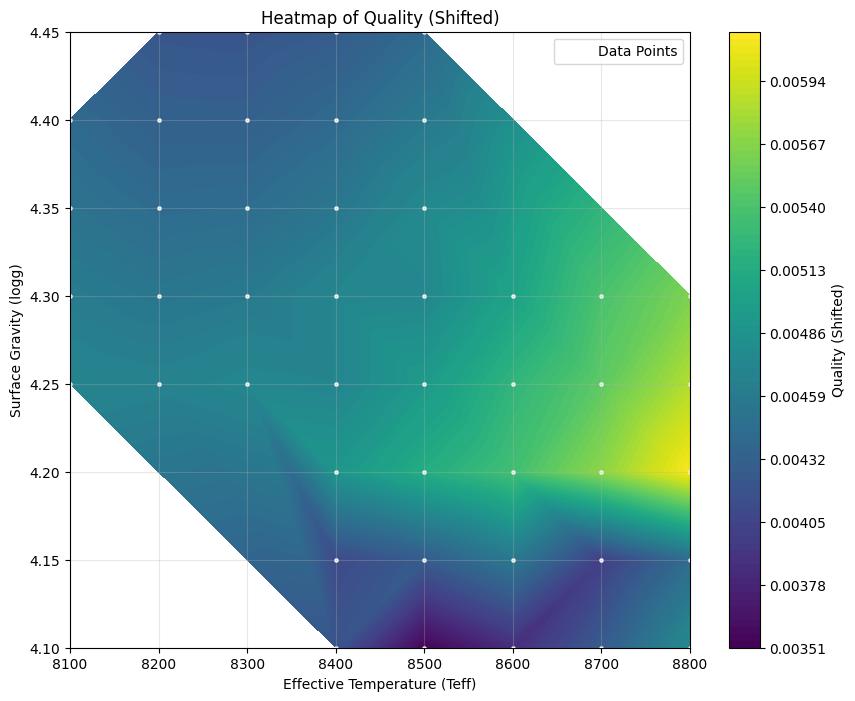

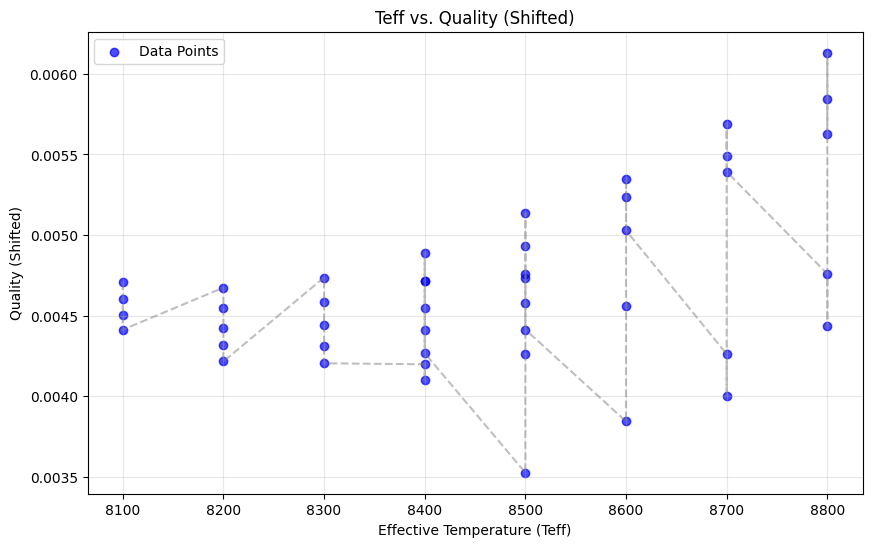

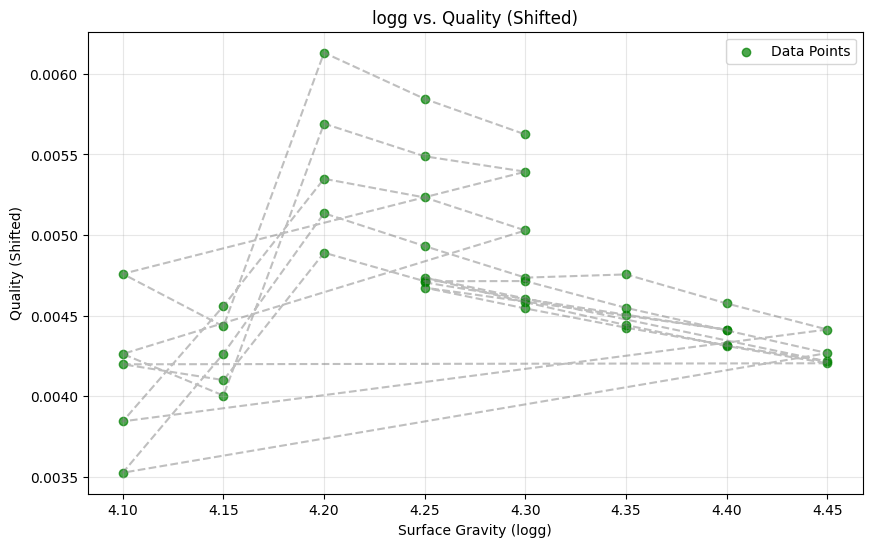

In [19]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Ergebnisse aus der JSON-Datei laden
with open('results.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# Werte extrahieren
teff = np.array([float(data['teff']) for data in results.values()])
logg = np.array([float(data['logg']) for data in results.values()])
quality_shifted = np.array([float(data['Quality_shifted']) for data in results.values()])

# 1. Heatmap: teff (x), logg (y), Quality_shifted (Farbskala)
plt.figure(figsize=(10, 8))
plt.tricontourf(teff, logg, quality_shifted, levels=100, cmap='viridis')  # Heatmap erstellen
plt.colorbar(label='Quality (Shifted)')
plt.scatter(teff, logg, c='white', s=5, label='Data Points')  # Punkte markieren
plt.xlabel('Effective Temperature (Teff)')
plt.ylabel('Surface Gravity (logg)')
plt.title('Heatmap of Quality (Shifted)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 2. Plot: Teff (x) vs. Quality (Shifted) (y)
plt.figure(figsize=(10, 6))
plt.scatter(teff, quality_shifted, color='blue', alpha=0.7, label='Data Points')
plt.plot(teff, quality_shifted, linestyle='dashed', alpha=0.5, color='gray')  # Verbindungslinien
plt.xlabel('Effective Temperature (Teff)')
plt.ylabel('Quality (Shifted)')
plt.title('Teff vs. Quality (Shifted)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# 3. Plot: logg (x) vs. Quality (Shifted) (y)
plt.figure(figsize=(10, 6))
plt.scatter(logg, quality_shifted, color='green', alpha=0.7, label='Data Points')
plt.plot(logg, quality_shifted, linestyle='dashed', alpha=0.5, color='gray')  # Verbindungslinien
plt.xlabel('Surface Gravity (logg)')
plt.ylabel('Quality (Shifted)')
plt.title('logg vs. Quality (Shifted)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()
